In [2]:
import glob
import sahi
import os
import json

import numpy as np

from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from sahi.utils.cv import read_image_as_pil

from matplotlib import pyplot as plt
import cv2
import pandas as pd
from ultralytics import YOLO

from sklearn.metrics import auc

In [3]:
from sahi.utils.yolov8 import (
    download_yolov8m_model,
)

from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from IPython.display import Image

## Auxiliary functions

In [4]:
def intersection_over_union(gt, pred):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(gt[0], pred[0])
    yA = max(gt[1], pred[1])
    xB = min(gt[2], pred[2])
    yB = min(gt[3], pred[3])
    # if there is no overlap between predicted and ground-truth box
    if xB < xA or yB < yA:
        return 0.0
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1)
    boxBArea = (pred[2] - pred[0] + 1) * (pred[3] - pred[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [5]:
# download YOLOV8m model to 'models/yolov5s6.pt'
yolov8_model_path = "models/yolov8m.pt"
download_yolov8m_model(yolov8_model_path)

In [6]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=yolov8_model_path,
    confidence_threshold=0.4,
    device="cuda:1", # or 'cuda:0'
)

In [7]:
predictions = get_prediction(read_image("people_frames/people_frames_10.jpg"), detection_model)

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [8]:
#results in form tlwh
results = predictions.to_coco_annotations()

In [9]:
image = cv2.imread("people_frames/people_frames_10.jpg")
height, width = image.shape[:2]

In [10]:
def xywh_tlbr(box):
    #get box (x_c, y_c, width, height) -> (tlbr)
    box[0]=box[0]-box[2]/2
    box[1]=box[1]-box[3]/2
    box[2]=box[0]+box[2]
    box[3]=box[1]+box[3]
    return box

In [11]:
def tlwh_tlbr(box):
    #get box (top left, width, height) -> (tlbr)
    box[2]=box[0]+box[2]
    box[3]=box[1]+box[3]
    return box

In [12]:
def scale_box(width, height, box):
    box[0]*=width
    box[2]*=width
    box[1]*=height
    box[3]*=height
    return box

### Unite all in one function

In [13]:
def compute_AP50(gt_path, predictions, image_path):
    '''
    compute AP50 for one image
    :param gt_path: path to GT labels
    :param predictions: predictions in coco format: tlwh
    :image_path: image - on which we compute predictions (need for width and height)
    :return: AP50
    '''

    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    with open(gt_path, "r") as f:
        boxes= f.readlines()
    #gt boxes are in the format x_c, y_c, width, height
    gt_boxes = [box.split(" ")[1:] for box in boxes if box.split(" ")[0]=='0'] #select only people (class 0)
    gt_boxes = [list(map(lambda x: float(x.strip()), box)) for box in gt_boxes]
    #convert from xywh to tlbr
    gt_boxes = [xywh_tlbr(box) for box in gt_boxes]
    #multiply by the image height and width
    gt_boxes = [scale_box(width, height, box) for box in gt_boxes]


    #dataframe for saving results of IOU computing
    predicted_boxes = pd.DataFrame(columns=['image', 'confidence', 'iou', 'TP', 'FP', 'Precision', 'Recall'], index=range(1000))
    i=0
    for result in predictions:
        if result['category_id']==0: #only person
            predicted_boxes.loc[i]['image'] = image_path
            predicted_boxes.loc[i]['confidence']=result['score']
            pr_box=result['bbox'].copy()
            pr_box=tlwh_tlbr(pr_box)
            ious=[]
            for gt_box in gt_boxes:
                iou = intersection_over_union(gt_box, pr_box)
                ious.append(iou)
            if max(ious)>0.5:
                predicted_boxes.loc[i]['iou']=max(ious)
                predicted_boxes.loc[i]['TP']=1
                predicted_boxes.loc[i]['FP']=0
            else:
                predicted_boxes.loc[i]['iou']=max(ious)
                predicted_boxes.loc[i]['FP']=1
                predicted_boxes.loc[i]['TP']=0
            i+=1
        else:
            continue

    num_gt = len(gt_boxes)

    #compute precision and recall
    predicted_boxes.sort_values(by='confidence', ascending=False)
    for i, row in predicted_boxes.iterrows():
        predicted_boxes.loc[i]['Precision']=predicted_boxes[:i+1]['TP'].sum()/len(predicted_boxes[:i+1])
        predicted_boxes.loc[i]['Recall']=predicted_boxes[:i+1]['TP'].sum()/num_gt


    #plot predictions
    for result in predictions:
        pr_box=result['bbox'].copy()
        pr_box=tlwh_tlbr(pr_box)
        cv2.rectangle(image, (int(pr_box[0]), int(pr_box[1])), (int(pr_box[2]), int(pr_box[3])), color=(0, 255, 0), thickness=2)

    #plot ground truth
    for box in gt_boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(255, 0, 0), thickness=2)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


    plt.figure(figsize=(9, 4))
    plt.plot(predicted_boxes['Recall'], predicted_boxes['Precision'])
    plt.title("Precision-Recall curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()



    ap50 = auc(predicted_boxes['Recall'], predicted_boxes['Precision'])
    print(f"AP50 = {ap50 :.4f}")



### Get usual predictions

In [14]:
predictions = get_prediction(read_image("people_frames/people_frames_10.jpg"), detection_model)
#results in form tlwh
results = predictions.to_coco_annotations()

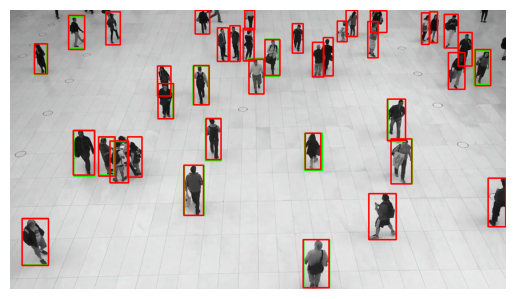

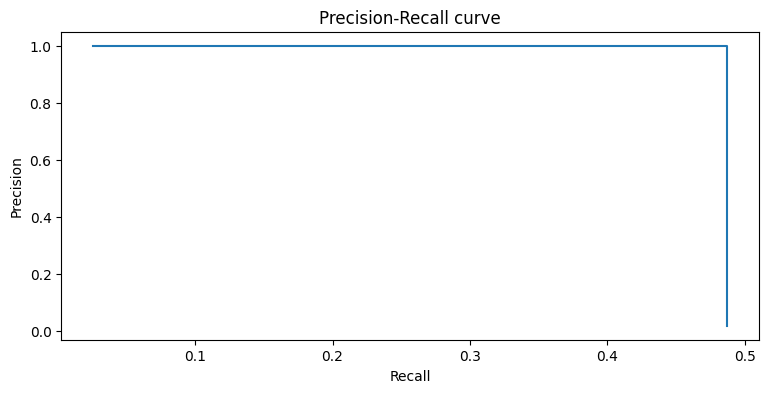

AP50 = 0.4615


In [15]:
compute_AP50("datasets/labels/people_frames_10.txt", results, "datasets/images/people_frames_10.jpg")

## Get sliced predictions

In [16]:
result = get_sliced_prediction(
    "people_frames/people_frames_10.jpg",
    detection_model,
    slice_height = 512,
    slice_width = 512,
    overlap_height_ratio = 0.8,
    overlap_width_ratio = 0.8
)

Performing prediction on 12 number of slices.


In [17]:
results = result.to_coco_annotations()

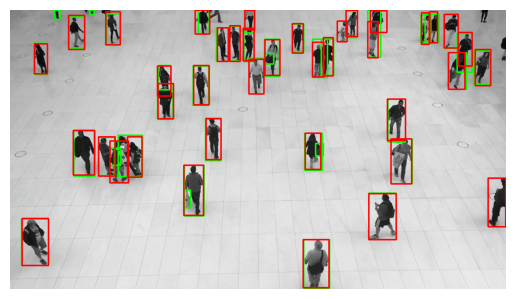

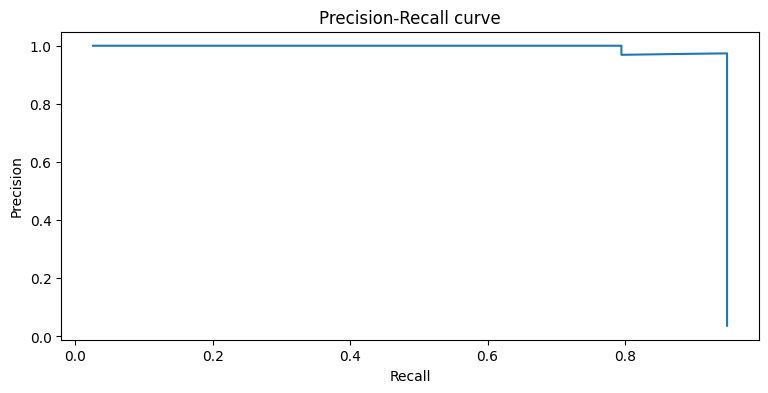

AP50 = 0.9187


In [18]:
compute_AP50("datasets/labels/people_frames_10.txt", results, "datasets/images/people_frames_10.jpg")

In [19]:
!wget http://images.cocodataset.org/zips/val2014.zip -O coco_val2014.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [20]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -O coco_ann2014.zip

UsageError: Cell magic `%%wget` not found.


In [38]:
# Opening JSON file
f = open('coco-2017/validation/new_labels.json')

# returns JSON object as
# a dictionary
data = json.load(f)

In [39]:
data

{'info': {'description': 'COCO 2017 Dataset',
  'url': 'http://cocodataset.org',
  'version': '1.0',
  'year': 2017,
  'contributor': 'COCO Consortium',
  'date_created': '2017/09/01',
  'licenses': [{'url': 'http://creativecommons.org/licenses/by-nc-sa/2.0/',
    'id': 1,
    'name': 'Attribution-NonCommercial-ShareAlike License'},
   {'url': 'http://creativecommons.org/licenses/by-nc/2.0/',
    'id': 2,
    'name': 'Attribution-NonCommercial License'},
   {'url': 'http://creativecommons.org/licenses/by-nc-nd/2.0/',
    'id': 3,
    'name': 'Attribution-NonCommercial-NoDerivs License'},
   {'url': 'http://creativecommons.org/licenses/by/2.0/',
    'id': 4,
    'name': 'Attribution License'},
   {'url': 'http://creativecommons.org/licenses/by-sa/2.0/',
    'id': 5,
    'name': 'Attribution-ShareAlike License'},
   {'url': 'http://creativecommons.org/licenses/by-nd/2.0/',
    'id': 6,
    'name': 'Attribution-NoDerivs License'},
   {'url': 'http://flickr.com/commons/usage/',
    'id': 7

In [104]:
def change_annotations_to_yolo(json_file, out_file):
    '''
    changes annotations from coco to yolo format: id from 0 to ....
    :param json_file: old file
    :param out_file: output file with new categories
    '''

    # Opening JSON file
    f = open(json_file)

    # returns JSON object as a dictionary
    data = json.load(f)

    annotations = data['annotations']
    for annotation in annotations:
        annotation['category_id']-=1

    data['annotations'] = annotations

    categories = data['categories']
    for category in categories:
        category['id']-=1

    data['categories'] = categories

    info_categories = data['info']['categories']
    for category in info_categories:
        category['id']-=1

    data['info']['categories'] = info_categories

    json_object = json.dumps(data, indent=4)

    # Writing to sample.json
    with open(out_file, "w") as outfile:
        outfile.write(json_object)



In [107]:
change_annotations_to_yolo("coco-2017/validation/labels.json", "coco-2017/validation/new_labels.json")

In [72]:
def convert_labels(x1, y1, x2, y2):
    '''
    Definition: Parses label files to extract label and bounding box
    coordinates. Converts (x1, y1, x1, y2) KITTI format to
    (x, y, width, height) normalized YOLO format.
    '''
    def sorting(l1, l2):
        if l1 > l2:
            lmax, lmin = l1, l2
            return lmax, lmin
        else:
            lmax, lmin = l2, l1
            return lmax, lmin

    xmax, xmin = sorting(x1, x2)
    ymax, ymin = sorting(y1, y2)

    x = (xmin + xmax)/2.0
    y = (ymin + ymax)/2.0
    w = xmax - xmin
    h = ymax - ymin

    return (x,y,w,h) #x_c, y_c, w, h

In [56]:
### Convert COCO annotations to YOLO format (x_c, y_c, width, height)/(width, height)

In [73]:
f = open("coco-2017/validation/new_labels.json")

training_data = json.load(f)

In [74]:
import cv2
check_set = set()
for i in range(len(training_data['annotations'])):
    image_id = str(training_data['annotations'][i]['image_id'])
    category_id = str(training_data['annotations'][i]['category_id'])
    bbox = training_data['annotations'][i]['bbox']
    # for image in training_data['images']:
    #     if str(image['id'])==str(image_id).strip():
    #         width = image['width']
    #         height = image['height']
    #         break

    kitti_bbox = [bbox[0], bbox[1], bbox[2] + bbox[0], bbox[3] + bbox[1]] #tlbr
    yolo_bbox = convert_labels(kitti_bbox[0], kitti_bbox[1], kitti_bbox[2], kitti_bbox[3])
    training_data['annotations'][i]['bbox'] = yolo_bbox

In [75]:
json_object = json.dumps(training_data, indent=4)

    # Writing to sample.json
with open("coco-2017/validation/new_labels.json", "w") as outfile:
    outfile.write(json_object)

In [1]:
from zipfile import ZipFile, BadZipFile
import os
def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)
        # remove zipfile
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)
    except BadZipFile as e:
        print("Error:", e)

In [2]:
extract_val_path = "./coco_val2014"
extract_ann_path="./coco_ann2014"

extract_zip_file(extract_val_path)
extract_zip_file(extract_ann_path)

In [102]:
import fiftyone as fo
import fiftyone.zoo as foz

In [106]:
# To download the COCO dataset for only the "person" and "car" classes
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections"],
    classes=["person"],
    max_samples=200,
    only_matching=True
)

09/01/2023 16:45:03 - INFO - fiftyone.zoo.datasets -   Downloading split 'validation' to 'C:\Users\user\fiftyone\coco-2017\validation' if necessary


09/01/2023 16:45:03 - INFO - fiftyone.utils.coco -   Downloading annotations to 'C:\Users\user\fiftyone\coco-2017\tmp-download\annotations_trainval2017.zip'


 100% |██████|    1.9Gb/1.9Gb [59.0s elapsed, 0s remaining, 36.8Mb/s]      


09/01/2023 16:46:02 - INFO - eta.core.utils -    100% |██████|    1.9Gb/1.9Gb [59.0s elapsed, 0s remaining, 36.8Mb/s]      


Extracting annotations to 'C:\Users\user\fiftyone\coco-2017\raw\instances_val2017.json'


09/01/2023 16:46:02 - INFO - fiftyone.utils.coco -   Extracting annotations to 'C:\Users\user\fiftyone\coco-2017\raw\instances_val2017.json'


09/01/2023 16:46:09 - INFO - fiftyone.utils.coco -   Downloading 200 images


 100% |██████████████████| 200/200 [12.0s elapsed, 0s remaining, 22.0 images/s]      


09/01/2023 16:46:21 - INFO - eta.core.utils -    100% |██████████████████| 200/200 [12.0s elapsed, 0s remaining, 22.0 images/s]      


Writing annotations for 200 downloaded samples to 'C:\Users\user\fiftyone\coco-2017\validation\labels.json'


09/01/2023 16:46:21 - INFO - fiftyone.utils.coco -   Writing annotations for 200 downloaded samples to 'C:\Users\user\fiftyone\coco-2017\validation\labels.json'


Dataset info written to 'C:\Users\user\fiftyone\coco-2017\info.json'


09/01/2023 16:46:21 - INFO - fiftyone.zoo.datasets -   Dataset info written to 'C:\Users\user\fiftyone\coco-2017\info.json'


Loading existing dataset 'coco-2017-validation-200'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


09/01/2023 16:46:21 - INFO - fiftyone.zoo.datasets -   Loading existing dataset 'coco-2017-validation-200'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


### Functions to predict and to evaluate

In [ ]:
# !sahi predict --source coco-2017/validation/data --dataset_json_path coco-2017/validation/new_labels.json --model_type yolov8 --model_path yolov8m.pt --slice_height 256 --slice_width 256 --overlap_height_ratio 0.2 --overlap_width_ratio 0.2 --model_confidence_threshold 0.25
#
#
# !sahi coco evaluate --dataset_json_path coco-2017/validation/new_labels.json --result_json_path runs/predict/exp_512_08/result.json --out_dir output/results_512_08

### SAHI results for different slice and overlap

In [101]:
sahi_results = pd.DataFrame(columns=["slice", "overlap", "mAP50", "mAP50s", "mAP50m", "mAP50l"], index=range(6))

In [102]:
for i, dir in enumerate(os.listdir("output")):
    parts = dir.split("_")
    slice = int(parts[1])
    overlap = int(parts[2])/10
    sahi_results.loc[i]['slice']=slice
    sahi_results.loc[i]['overlap']=overlap

    f = open(f"output/{dir}/eval.json")
    results = json.load(f)
    sahi_results.loc[i]['mAP50'] = results["bbox_mAP50"]
    sahi_results.loc[i]['mAP50s'] = results["bbox_mAP50_s"]
    sahi_results.loc[i]['mAP50m'] = results["bbox_mAP50_m"]
    sahi_results.loc[i]['mAP50l'] = results["bbox_mAP50_l"]

In [103]:
sahi_results

,slice,overlap,mAP50,mAP50s,mAP50m,mAP50l
0,256,0.2,0.095,0.108,0.113,0.165
1,256,0.5,0.091,0.104,0.111,0.152
2,256,0.8,0.092,0.115,0.125,0.153
3,512,0.2,0.112,0.115,0.11,0.183
4,512,0.5,0.112,0.115,0.11,0.183
5,512,0.8,0.115,0.125,0.11,0.172


In [104]:
sahi_results.set_index(['slice', 'overlap'], inplace=True)

In [105]:
sahi_results

mAP50 mAP50s mAP50m mAP50l
slice overlap                            
256   0.2      0.095  0.108  0.113  0.165
      0.5      0.091  0.104  0.111  0.152
      0.8      0.092  0.115  0.125  0.153
512   0.2      0.112  0.115   0.11  0.183
      0.5      0.112  0.115   0.11  0.183
      0.8      0.115  0.125   0.11  0.172

<Figure size 1200x400 with 0 Axes>

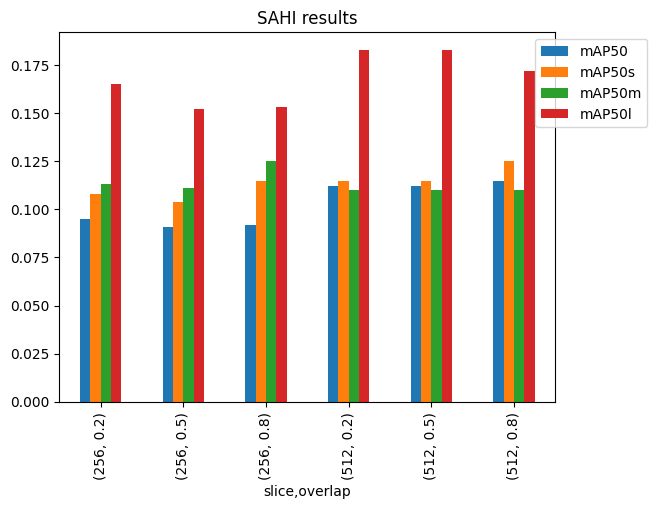

In [108]:
plt.figure(figsize=(12,4))
sahi_results.plot(kind='bar');
plt.title("SAHI results");
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.show();

In [ ]:
### Draw bbox of coco-2017 labels and predicted bbox

In [4]:
f = open("coco-2017/validation/new_labels.json")

training_data = json.load(f)

In [5]:
training_data['images']

[{'license': 1,
  'file_name': '000000017627.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000017627.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-16 15:13:53',
  'flickr_url': 'http://farm5.staticflickr.com/4145/4977243989_c2efb1b911_z.jpg',
  'id': 17627},
 {'license': 3,
  'file_name': '000000025560.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000025560.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-17 21:48:19',
  'flickr_url': 'http://farm1.staticflickr.com/198/488201322_ef2ebfeccb_z.jpg',
  'id': 25560},
 {'license': 3,
  'file_name': '000000016228.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000016228.jpg',
  'height': 440,
  'width': 640,
  'date_captured': '2013-11-19 00:09:53',
  'flickr_url': 'http://farm4.staticflickr.com/3737/10031812195_372ae7538f_z.jpg',
  'id': 16228},
 {'license': 1,
  'file_name': '000000035197.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000035

In [127]:
image_id=13729
for image in training_data['images']:
    if str(image['id'])==str(image_id):
        image_path = image['file_name']
        break

(-0.5, 639.5, 479.5, -0.5)

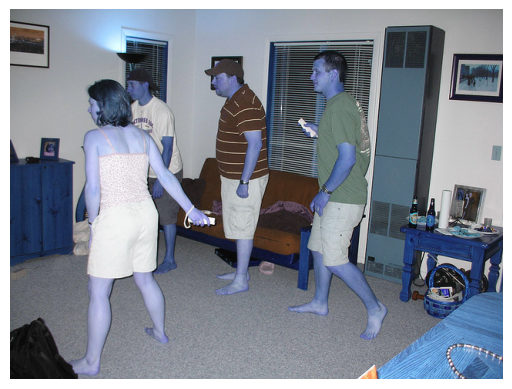

In [128]:
image = cv2.imread(f"coco-2017/validation/data/{image_path}")
plt.imshow(image);
plt.axis("off")

In [131]:
def draw_annotations(image, image_id, json_file, color):
    '''
    draw annotations on image with image_id from json_file
    :param image_id:
    :return:
    '''

    f = open(json_file)

    data = json.load(f)

    try:
        annotations = training_data['annotations']
    except TypeError:
        annotations = data

    for annotation in annotations:
        if annotation['image_id']==image_id: #only persons
            box=annotation['bbox']
            x1, y1 = float(box[0]), float(box[1])
            width, height = float(box[2]), float(box[3])
            x2 = x1+width
            y2 = y1+height
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color=color, thickness=2)
    plt.imshow(image)
    plt.axis("off")

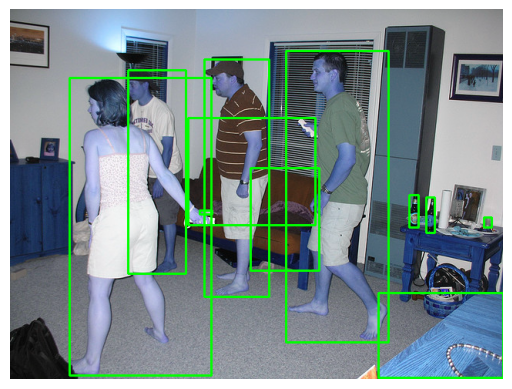

In [132]:
draw_annotations(image, 13729, "coco-2017/validation/new_labels.json", color=(0, 255, 0))

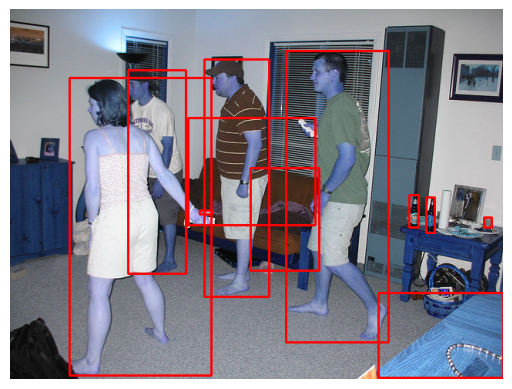

In [134]:
draw_annotations(image, 13729, "runs/predict/exp_512_02/result.json", color=(255, 0, 0))

In [45]:
def make_prediction(image_dir, destination_dir):

    for image in glob.glob(f"{image_dir}/*.jpg"):

        predictions = get_sliced_prediction(
        image,
        detection_model,
        slice_height = 512,
        slice_width = 512,
        overlap_height_ratio = 0.2,
        overlap_width_ratio = 0.2
        )

        print(image)
        file_name = image.split("\\")[-1].split(".")[0]
        print(file_name)

        results = predictions.to_coco_annotations()

        with open(f"{destination_dir}/{file_name}.txt", "w+") as f:
            for result in results:
                f.write(str(result['category_id'])+" ")
                f.write(" {:.8f}".format(result['score']))
                for box in result['bbox']:
                    f.write(" {:.8f}".format(box))
                f.write("\n")


In [65]:
make_prediction("test_dataset/images", "test")

Performing prediction on 6 number of slices.
test_dataset/images\people_frames_1.jpg
people_frames_1
Performing prediction on 6 number of slices.
test_dataset/images\people_frames_10.jpg
people_frames_10
Performing prediction on 6 number of slices.
test_dataset/images\people_frames_100.jpg
people_frames_100
Performing prediction on 6 number of slices.
test_dataset/images\people_frames_101.jpg
people_frames_101
Performing prediction on 6 number of slices.
test_dataset/images\people_frames_11.jpg
people_frames_11
Performing prediction on 6 number of slices.
test_dataset/images\people_frames_12.jpg
people_frames_12
Performing prediction on 6 number of slices.
test_dataset/images\people_frames_13.jpg
people_frames_13
Performing prediction on 6 number of slices.
test_dataset/images\people_frames_14.jpg
people_frames_14
Performing prediction on 6 number of slices.
test_dataset/images\people_frames_15.jpg
people_frames_15
Performing prediction on 6 number of slices.
test_dataset/images\people

In [61]:
def compute_AP50_all(gt_dir, predictions_dir, image_dir):
    '''
    compute AP50 for batch of images
    :param gt_path: path to GT labels
    :param predictions: predictions in coco format: tlwh
    :image_path: image - on which we compute predictions (need for width and height)
    :return: AP50
    '''

    #dataframe for saving results of IOU computing
    predicted_boxes = pd.DataFrame(columns=['image', 'confidence', 'iou', 'TP', 'FP', 'Precision', 'Recall'], index=range(10000))

    num_gt=0
    i=0


    for image_path in glob.glob(f"{image_dir}/*.jpg"):

        image = cv2.imread(image_path)
        height, width = image.shape[:2]

        file_name = image_path.split("\\")[-1].split(".")[0]

        gt_path = f"{gt_dir}/{file_name}.txt"

        with open(gt_path, "r") as f:
            boxes= f.readlines()

        #gt boxes are in the format x_c, y_c, width, height
        gt_boxes = [box.split(" ")[1:] for box in boxes if box.split(" ")[0]=="0"] #only people
        gt_boxes = [list(map(lambda x: float(x.strip()), box)) for box in gt_boxes]
        #convert from xywh to tlbr
        gt_boxes = [xywh_tlbr(box) for box in gt_boxes]
        #multiply by the image height and width
        gt_boxes = [scale_box(width, height, box) for box in gt_boxes]


        num_gt += len(gt_boxes)


        predictions_path = f"{predictions_dir}/{file_name}.txt"

        with open(predictions_path, "r") as f:
            predictions = f.readlines()


        for result in predictions:
            prediction = result.split(" ")
            category_id = prediction[0]

            if category_id=='0': #only person
                predicted_boxes.loc[i]['image'] = file_name
                predicted_boxes.loc[i]['confidence']=float(prediction[2])
                pr_box=list(map(lambda x: float(x.strip()), prediction[3:]))
                pr_box=tlwh_tlbr(pr_box)
                #print(pr_box)
                ious=[]
                for gt_box in gt_boxes:
                    iou = intersection_over_union(gt_box, pr_box)
                    ious.append(iou)
                if max(ious)>0.5:
                    predicted_boxes.loc[i]['iou']=max(ious)
                    predicted_boxes.loc[i]['TP']=1
                    predicted_boxes.loc[i]['FP']=0


                else:
                    predicted_boxes.loc[i]['iou']=max(ious)
                    predicted_boxes.loc[i]['FP']=1
                    predicted_boxes.loc[i]['TP']=0

                i+=1

            else:
                continue




    #compute precision and recall
    predicted_boxes.sort_values(by='confidence', ascending=False, inplace=True)

    #NMS


    for i, row in predicted_boxes.iterrows():
        predicted_boxes.loc[i]['Precision']=predicted_boxes[:i+1]['TP'].sum()/len(predicted_boxes[:i+1])
        predicted_boxes.loc[i]['Recall']=predicted_boxes[:i+1]['TP'].sum()/num_gt



    #plot predictions
        # for result in predictions:
        #     pr_box=result['bbox'].copy()
        #     pr_box=tlwh_tlbr(pr_box)
        #     cv2.rectangle(image, (int(pr_box[0]), int(pr_box[1])), (int(pr_box[2]), int(pr_box[3])), color=(0, 255, 0), thickness=2)

        # #plot ground truth
        # for box in gt_boxes:
        #     cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(255, 0, 0), thickness=2)
        # plt.imshow(image)
        # plt.axis('off')
        # plt.show()


    plt.figure(figsize=(9, 4))
    plt.plot(predicted_boxes['Recall'], predicted_boxes['Precision'])
    plt.title("Precision-Recall curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

    predicted_boxes.dropna(thresh=3, inplace=True)

    ap50 = auc(predicted_boxes['Recall'], predicted_boxes['Precision'])
    print(f"AP50 = {ap50 :.4f}")

    return predicted_boxes

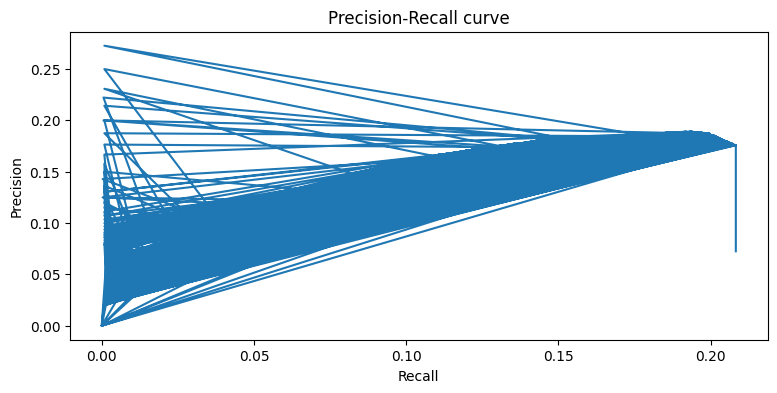

ValueError: x is neither increasing nor decreasing : [0.002585463947141626 0.002298190175237001 0.002298190175237001 ... 0.1016949152542373 0.006032749209997127 0.14220051709278944].

In [66]:
data = compute_AP50_all("test_dataset/labels", "test", "test_dataset/images")

In [60]:
data

,image,confidence,iou,TP,FP,Precision,Recall
123,76b9dd03838254d5,0.948018,0.833528,1,0,0.991935,0.03236
152,85d5916aeedf0f8d,0.935876,0.966458,1,0,0.986928,0.039726
153,85d5916aeedf0f8d,0.931335,0.968614,1,0,0.987013,0.039989
3043,people_frames_17,0.930872,0.921034,1,0,0.956636,0.766114
102,6c7342a64049c0da,0.930623,0.968021,1,0,0.990291,0.026835
...,...,...,...,...,...,...,...
9995,NaN,NaN,NaN,NaN,NaN,0.334234,0.878979
9996,NaN,NaN,NaN,NaN,NaN,0.3342,0.878979
9997,NaN,NaN,NaN,NaN,NaN,0.334167,0.878979
9998,NaN,NaN,NaN,NaN,NaN,0.334133,0.878979


In [38]:
data=data.dropna()

In [39]:
data

,image,confidence,iou,TP,FP,Precision,Recall
0,people_frames_88,0.914794,0.0,0,1,0.0,0.0
1,people_frames_88,0.901582,0.384478,0,1,0.0,0.0
2,people_frames_88,0.901301,0.0,0,1,0.0,0.0
3,people_frames_88,0.898999,0.0,0,1,0.0,0.0
4,people_frames_88,0.88797,0.107097,0,1,0.0,0.0
...,...,...,...,...,...,...,...
4335,people_frames_62,0.481531,0.006675,0,1,0.201338,0.229676
4336,people_frames_62,0.478903,0.0,0,1,0.201291,0.229676
4337,people_frames_62,0.442171,0.0,0,1,0.201245,0.229676
4338,people_frames_62,0.435113,0.0,0,1,0.201198,0.229676


In [15]:
def show_annotations(image_dir, annotations_dir):
    image = cv2.imread(image_dir)

    height, width = image.shape[:2]


    with open(annotations_dir, "r") as f:
        boxes = f.readlines()

    gt_boxes = [box.split(" ")[1:] for box in boxes if box.split(" ")[0]=="0"] #only people
    gt_boxes = [list(map(lambda x: float(x.strip()), box)) for box in gt_boxes]
        #convert from xywh to tlbr
    gt_boxes = [xywh_tlbr(box) for box in gt_boxes]
        #multiply by the image height and width
    gt_boxes = [scale_box(width, height, box) for box in gt_boxes]

    #plot ground truth
    for box in gt_boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(255, 0, 0), thickness=2)
    plt.imshow(image)
    plt.axis('off')
    plt.show()




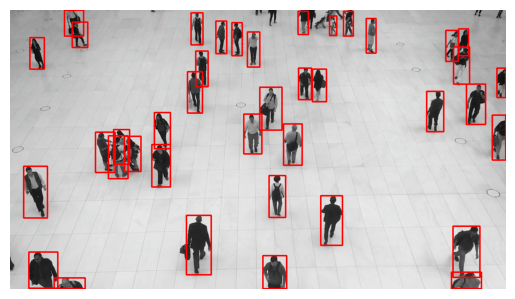

In [36]:
show_annotations("datasets/images/people_frames_113.jpg", "datasets/labels/people_frames_113.txt")

In [22]:
with open("people/obj_train_data/people_frames_2.txt", "r") as f:
    pass

FileNotFoundError: [Errno 2] No such file or directory: 'people/obj_train_data/people_frames_2.txt'

In [102]:
import os
files = os.listdir("people/obj_train_data")

for file_name in files:
    with open(f"people/obj_train_data/{file_name}", "r") as f:
        lines = f.readlines()
        if len(lines)>0: #if there is annotation for this file - copy it and annotations to the datasets dir
            print(file_name)

FileNotFoundError: [Errno 2] No such file or directory: 'people/obj_train_data'